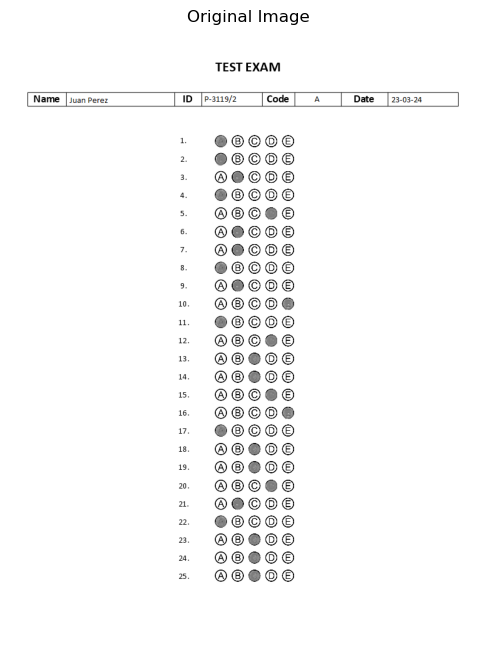

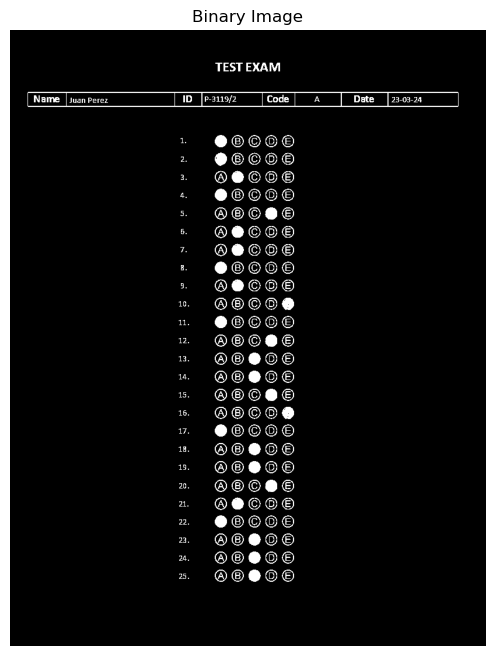

Image processing completed successfully.


In [7]:
import cv2
import numpy as np
import os
import matplotlib.pyplot as plt

# Function to display images
def mostrar_imagen(imagen, titulo="Imagen"):
    # Convert from BGR to RGB for correct display with matplotlib
    if len(imagen.shape) == 3 and imagen.shape[2] == 3:
        imagen_rgb = cv2.cvtColor(imagen, cv2.COLOR_BGR2RGB)
    else:
        imagen_rgb = imagen  # Already grayscale or binary
        
    plt.figure(figsize=(10, 8))
    plt.title(titulo)
    plt.imshow(imagen_rgb, cmap='gray' if len(imagen.shape) == 2 else None)
    plt.axis('off')
    plt.show()

# Function to obtain binary image
def obtener_imagen_binaria(imagen, umbral=200):
    """
    Converts an image to binary format for easier processing.
    
    Args:
        imagen: Input image (BGR format)
        umbral: Threshold value for binarization
        
    Returns:
        Binary image (white objects on black background)
    """
    # Convert to grayscale
    gris = cv2.cvtColor(imagen, cv2.COLOR_BGR2GRAY)
    
    # Apply threshold to get binary image
    _, binaria = cv2.threshold(gris, umbral, 255, cv2.THRESH_BINARY_INV)
    
    return binaria

# Test the functions with a sample image
if __name__ == "__main__":
    # Path to the test image
    ruta_imagen = r"./multiple_choice_1.png"
    
    # Check if the image exists
    if not os.path.exists(ruta_imagen):
        print(f"Error: Image not found at {ruta_imagen}")
    else:
        # Read the image
        imagen = cv2.imread(ruta_imagen)
        
        if imagen is None:
            print(f"Error: Could not read the image at {ruta_imagen}")
        else:
            # Display original image
            mostrar_imagen(imagen, "Original Image")
            
            # Get and display binary image
            binaria = obtener_imagen_binaria(imagen)
            mostrar_imagen(binaria, "Binary Image")
            
            print("Image processing completed successfully.")

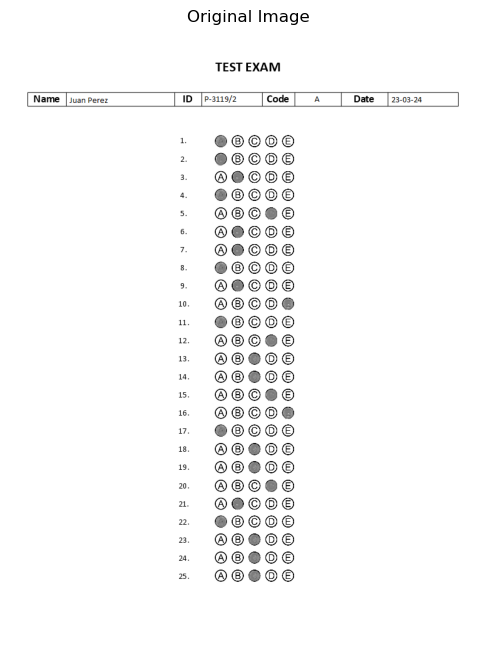

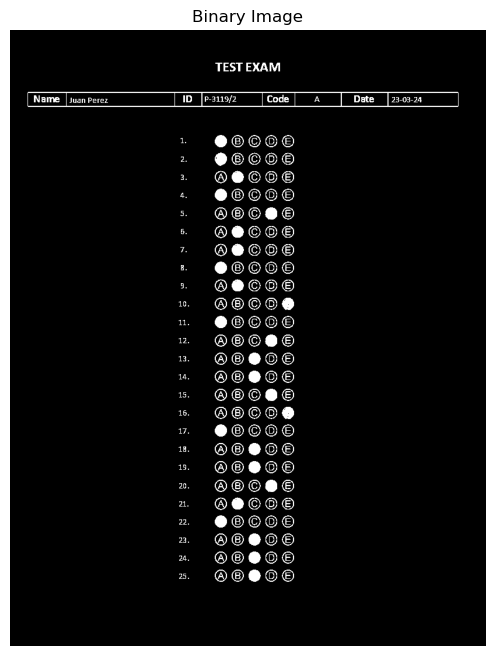

Detected 125 circles


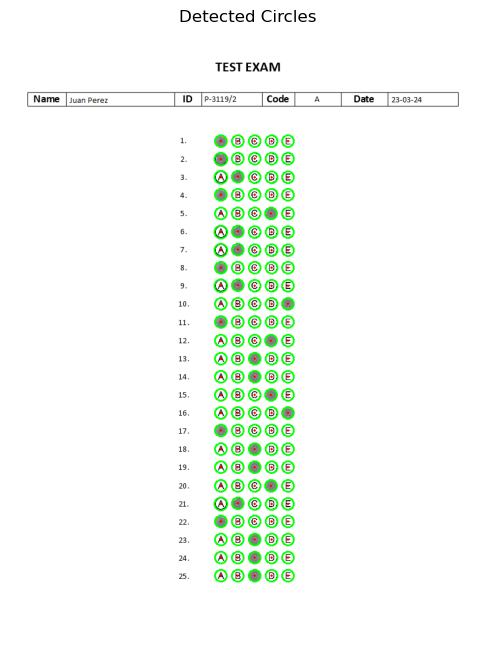

Image processing completed successfully.


In [8]:
# Function to detect circles in the binary image
def detectar_circulos(imagen_binaria, min_circularidad=0.7, min_ancho=15, max_ancho=40, min_alto=15, max_alto=40):
    """
    Detects circles in a binary image that could represent answer options.
    
    Args:
        imagen_binaria: Binary image with white objects on black background
        min_circularidad: Minimum circularity value to consider a contour as a circle
        min_ancho, max_ancho, min_alto, max_alto: Size constraints for the circles
        
    Returns:
        List of detected circles with their coordinates and radius
    """
    # Find contours in the binary image
    contornos, _ = cv2.findContours(imagen_binaria, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    # List to store detected circles
    circulos = []
    
    # Process each contour
    for contorno in contornos:
        # Calculate area and perimeter
        area = cv2.contourArea(contorno)
        perimetro = cv2.arcLength(contorno, True)
        
        # Calculate circularity
        if perimetro > 0:
            circularidad = 4 * np.pi * area / (perimetro * perimetro)
            
            # If it's approximately circular
            if circularidad > min_circularidad:
                x, y, w, h = cv2.boundingRect(contorno)
                
                # Filter by size
                if min_ancho < w < max_ancho and min_alto < h < max_alto:
                    centro_x = x + w//2
                    centro_y = y + h//2
                    radio = max(w, h) // 2
                    circulos.append((centro_x, centro_y, radio, contorno))
    
    return circulos

# Function to visualize detected circles
def visualizar_circulos(imagen_original, circulos):
    """
    Creates a visualization of the detected circles on the original image.
    
    Args:
        imagen_original: Original image
        circulos: List of detected circles (x, y, radius, contour)
        
    Returns:
        Image with circles drawn on it
    """
    # Create a copy of the original image
    imagen_con_circulos = imagen_original.copy()
    
    # Draw each circle
    for cx, cy, r, _ in circulos:
        cv2.circle(imagen_con_circulos, (cx, cy), r, (0, 255, 0), 2)
        cv2.circle(imagen_con_circulos, (cx, cy), 2, (0, 0, 255), -1)  # Center point
    
    return imagen_con_circulos

# Test the functions with a sample image
if __name__ == "__main__":
    # Path to the test image
    ruta_imagen = r"./multiple_choice_1.png"
    
    # Check if the image exists
    if not os.path.exists(ruta_imagen):
        print(f"Error: Image not found at {ruta_imagen}")
    else:
        # Read the image
        imagen = cv2.imread(ruta_imagen)
        
        if imagen is None:
            print(f"Error: Could not read the image at {ruta_imagen}")
        else:
            # Display original image
            mostrar_imagen(imagen, "Original Image")
            
            # Get binary image
            binaria = obtener_imagen_binaria(imagen)
            mostrar_imagen(binaria, "Binary Image")
            
            # Detect circles
            circulos_detectados = detectar_circulos(binaria)
            print(f"Detected {len(circulos_detectados)} circles")
            
            # Visualize detected circles
            imagen_con_circulos = visualizar_circulos(imagen, circulos_detectados)
            mostrar_imagen(imagen_con_circulos, "Detected Circles")
            
            print("Image processing completed successfully.")

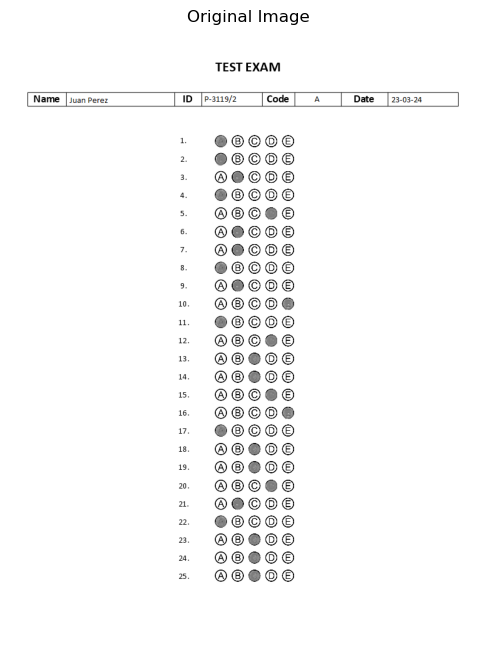

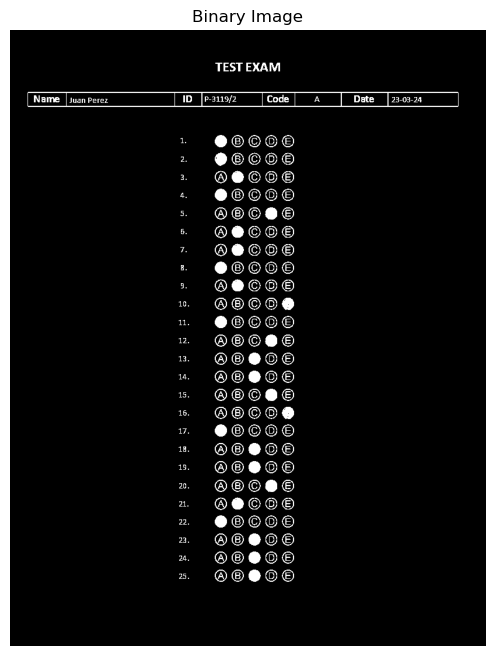

Detected 125 circles
Grouped into 25 questions


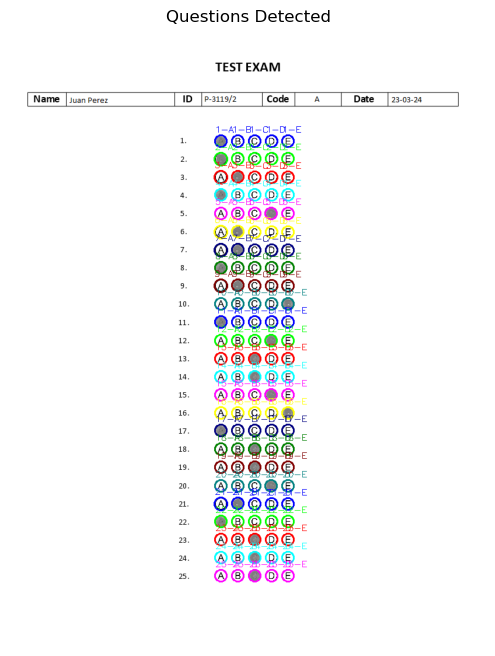

Image processing completed successfully.


In [9]:
# Function to group circles into questions (rows of 5 options)
def agrupar_circulos_en_preguntas(circulos, tolerancia_y=15):
    """
    Groups detected circles into rows of 5, each representing a question.
    
    Args:
        circulos: List of detected circles (x, y, radius, contour)
        tolerancia_y: Vertical tolerance to consider circles in the same row
        
    Returns:
        Dictionary with question numbers as keys and lists of circles as values
    """
    if not circulos:
        return {}
    
    # Sort circles by y-coordinate (vertically)
    circulos_ordenados = sorted(circulos, key=lambda c: c[1])
    
    # Group circles into rows based on y-coordinate
    filas = []
    fila_actual = [circulos_ordenados[0]]
    y_actual = circulos_ordenados[0][1]
    
    for circulo in circulos_ordenados[1:]:
        if abs(circulo[1] - y_actual) <= tolerancia_y:
            # Same row
            fila_actual.append(circulo)
        else:
            # New row
            if len(fila_actual) > 0:
                filas.append(fila_actual)
            fila_actual = [circulo]
            y_actual = circulo[1]
    
    # Add the last row if not empty
    if len(fila_actual) > 0:
        filas.append(fila_actual)
    
    # Sort each row by x-coordinate (horizontally)
    for i in range(len(filas)):
        filas[i] = sorted(filas[i], key=lambda c: c[0])
    
    # Create dictionary of questions
    preguntas = {}
    for i, fila in enumerate(filas):
        if len(fila) == 5:  # Only consider rows with exactly 5 circles (A, B, C, D, E options)
            preguntas[i + 1] = fila  # Question numbers start from 1
    
    return preguntas

# Function to visualize questions
def visualizar_preguntas(imagen_original, preguntas):
    """
    Creates a visualization of the grouped circles (questions) on the original image.
    
    Args:
        imagen_original: Original image
        preguntas: Dictionary with question numbers and their circles
        
    Returns:
        Image with questions visualized
    """
    # Create a copy of the original image
    imagen_con_preguntas = imagen_original.copy()
    
    # Colors for different questions
    colores = [
        (255, 0, 0),    # Blue
        (0, 255, 0),    # Green
        (0, 0, 255),    # Red
        (255, 255, 0),  # Cyan
        (255, 0, 255),  # Magenta
        (0, 255, 255),  # Yellow
        (128, 0, 0),    # Dark blue
        (0, 128, 0),    # Dark green
        (0, 0, 128),    # Dark red
        (128, 128, 0),  # Dark cyan
    ]
    
    # Draw each question with a different color
    for num_pregunta, circulos in preguntas.items():
        color = colores[(num_pregunta - 1) % len(colores)]
        
        # Draw each circle in the question
        for i, (cx, cy, r, _) in enumerate(circulos):
            cv2.circle(imagen_con_preguntas, (cx, cy), r, color, 2)
            
            # Add option letter (A, B, C, D, E)
            opcion = chr(65 + i)  # ASCII: A=65, B=66, etc.
            cv2.putText(imagen_con_preguntas, f"{num_pregunta}-{opcion}", 
                       (cx - r, cy - r - 5), cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 1)
    
    return imagen_con_preguntas

# Update the test code
if __name__ == "__main__":
    # Path to the test image
    ruta_imagen = r"./multiple_choice_1.png"
    
    # Check if the image exists
    if not os.path.exists(ruta_imagen):
        print(f"Error: Image not found at {ruta_imagen}")
    else:
        # Read the image
        imagen = cv2.imread(ruta_imagen)
        
        if imagen is None:
            print(f"Error: Could not read the image at {ruta_imagen}")
        else:
            # Display original image
            mostrar_imagen(imagen, "Original Image")
            
            # Get binary image
            binaria = obtener_imagen_binaria(imagen)
            mostrar_imagen(binaria, "Binary Image")
            
            # Detect circles
            circulos_detectados = detectar_circulos(binaria)
            print(f"Detected {len(circulos_detectados)} circles")
            
            # Group circles into questions
            preguntas = agrupar_circulos_en_preguntas(circulos_detectados)
            print(f"Grouped into {len(preguntas)} questions")
            
            # Visualize questions
            imagen_con_preguntas = visualizar_preguntas(imagen, preguntas)
            mostrar_imagen(imagen_con_preguntas, "Questions Detected")
            
            print("Image processing completed successfully.")

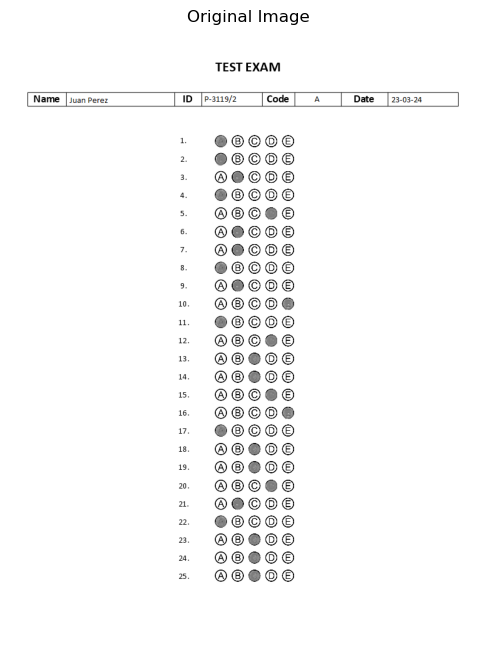

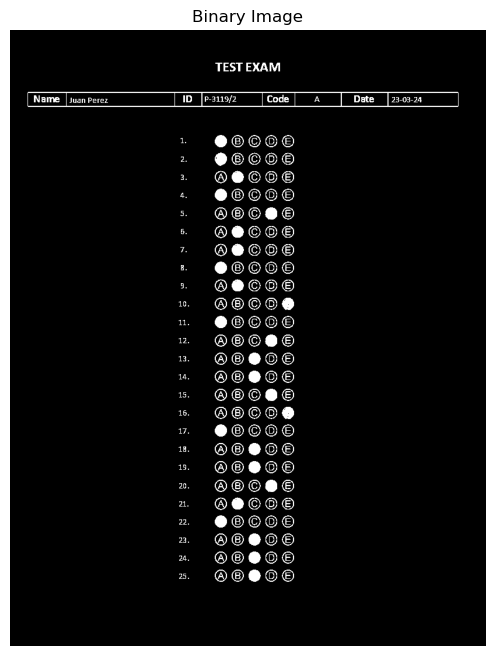

Detected 125 circles
Grouped into 25 questions

Detected answers:
Question 1: A
Question 2: A
Question 3: B
Question 4: A
Question 5: D
Question 6: B
Question 7: B
Question 8: A
Question 9: B
Question 10: E
Question 11: A
Question 12: D
Question 13: C
Question 14: C
Question 15: D
Question 16: E
Question 17: A
Question 18: C
Question 19: C
Question 20: D
Question 21: B
Question 22: A
Question 23: C
Question 24: C
Question 25: C


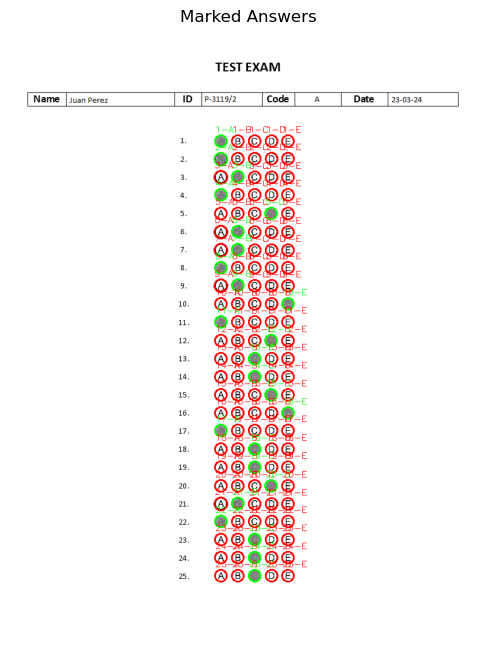

Image processing completed successfully.


In [ ]:
# Function to determine which circles are marked (filled in)
def detectar_circulos_marcados(imagen, preguntas, umbral_marcado=150):
    """
    Determines which circles are marked (filled in) for each question.
    
    Args:
        imagen: Original image
        preguntas: Dictionary with question numbers and their circles
        umbral_marcado: Threshold to consider a circle as marked
        
    Returns:
        Dictionary with question numbers as keys and lists of marked options as values
    """
    # Convert image to grayscale
    gris = cv2.cvtColor(imagen, cv2.COLOR_BGR2GRAY)
    
    # Dictionary to store marked options for each question
    respuestas = {}
    
    # Options labels
    opciones = ['A', 'B', 'C', 'D', 'E']
    
    # Check each question
    for num_pregunta, circulos in preguntas.items():
        respuestas[num_pregunta] = []
        
        # Check each option in the question
        for i, (cx, cy, r, _) in enumerate(circulos):
            # Create a mask for the circle
            mask = np.zeros(gris.shape, dtype=np.uint8)
            cv2.circle(mask, (cx, cy), r, 255, -1)
            
            # Calculate the mean intensity inside the circle
            mean_val = cv2.mean(gris, mask=mask)[0]
            
            # If the mean intensity is below the threshold, consider it marked
            if mean_val < umbral_marcado:
                respuestas[num_pregunta].append(opciones[i])
    
    return respuestas

# Function to visualize marked answers
def visualizar_respuestas(imagen_original, preguntas, respuestas):
    """
    Creates a visualization of the marked answers on the original image.
    
    Args:
        imagen_original: Original image
        preguntas: Dictionary with question numbers and their circles
        respuestas: Dictionary with question numbers and marked options
        
    Returns:
        Image with marked answers visualized
    """
    # Create a copy of the original image
    imagen_con_respuestas = imagen_original.copy()
    
    # Options labels
    opciones = ['A', 'B', 'C', 'D', 'E']
    
    # Draw each question
    for num_pregunta, circulos in preguntas.items():
        # Get marked options for this question
        opciones_marcadas = respuestas.get(num_pregunta, [])
        
        # Draw each circle in the question
        for i, (cx, cy, r, _) in enumerate(circulos):
            # Determine if this option is marked
            is_marked = opciones[i] in opciones_marcadas
            
            # Set color based on whether the option is marked
            color = (0, 255, 0) if is_marked else (0, 0, 255)  # Green if marked, red if not
            
            # Draw the circle
            cv2.circle(imagen_con_respuestas, (cx, cy), r, color, 2)
            
            # Add option label
            cv2.putText(imagen_con_respuestas, f"{num_pregunta}-{opciones[i]}", 
                       (cx - r, cy - r - 5), cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 1)
    
    return imagen_con_respuestas


In [11]:
# Define the correct answers
respuestas_correctas = {
    1: 'A', 2: 'A', 3: 'B', 4: 'A', 5: 'D',
    6: 'B', 7: 'B', 8: 'C', 9: 'B', 10: 'A',
    11: 'D', 12: 'A', 13: 'C', 14: 'C', 15: 'D',
    16: 'B', 17: 'A', 18: 'C', 19: 'C', 20: 'D',
    21: 'B', 22: 'A', 23: 'C', 24: 'C', 25: 'C'
}

# Function to compare detected answers with correct answers
def evaluar_respuestas(respuestas_detectadas, respuestas_correctas):
    """
    Compares detected answers with correct answers and calculates the score.
    
    Args:
        respuestas_detectadas: Dictionary with detected answers
        respuestas_correctas: Dictionary with correct answers
        
    Returns:
        Dictionary with evaluation results
    """
    correctas = 0
    incorrectas = 0
    no_contestadas = 0
    puntaje = 0
    
    # Details of each question's evaluation
    detalles = {}
    
    # Check each question
    for num_pregunta, respuesta_correcta in respuestas_correctas.items():
        # Get detected answer for this question
        opciones_marcadas = respuestas_detectadas.get(num_pregunta, [])
        
        if not opciones_marcadas:
            # No answer detected
            no_contestadas += 1
            resultado = "No contestada"
            # No points for unanswered questions
        elif len(opciones_marcadas) == 1 and opciones_marcadas[0] == respuesta_correcta:
            # Correct answer
            correctas += 1
            resultado = "Correcta"
            puntaje += 4  # 4 points for correct answer
        else:
            # Incorrect answer
            incorrectas += 1
            resultado = "Incorrecta"
            puntaje -= 1  # -1 point for incorrect answer
        
        # Store details for this question
        detalles[num_pregunta] = {
            "respuesta_correcta": respuesta_correcta,
            "respuesta_marcada": opciones_marcadas,
            "resultado": resultado
        }
    
    # Ensure score is not negative
    puntaje = max(0, puntaje)
    
    return {
        "correctas": correctas,
        "incorrectas": incorrectas,
        "no_contestadas": no_contestadas,
        "puntaje": puntaje,
        "puntaje_maximo": len(respuestas_correctas) * 4,
        "detalles": detalles
    }



EXAMEN N° 1


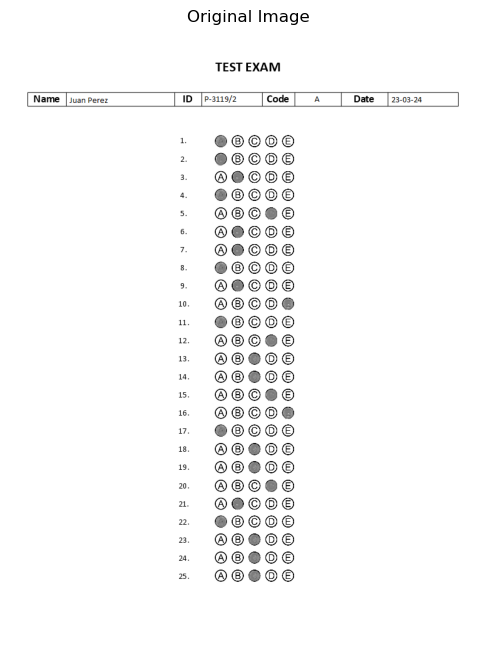

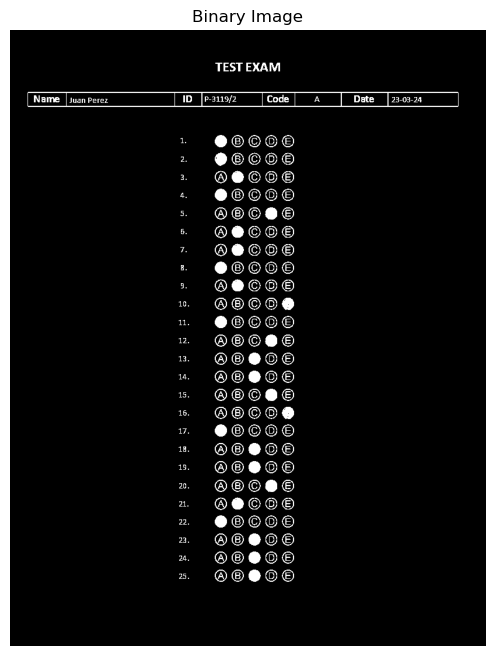

Detected 125 circles
Grouped into 25 questions

Detected answers:
Question 1: A
Question 2: A
Question 3: B
Question 4: A
Question 5: D
Question 6: B
Question 7: B
Question 8: A
Question 9: B
Question 10: E
Question 11: A
Question 12: D
Question 13: C
Question 14: C
Question 15: D
Question 16: E
Question 17: A
Question 18: C
Question 19: C
Question 20: D
Question 21: B
Question 22: A
Question 23: C
Question 24: C
Question 25: C


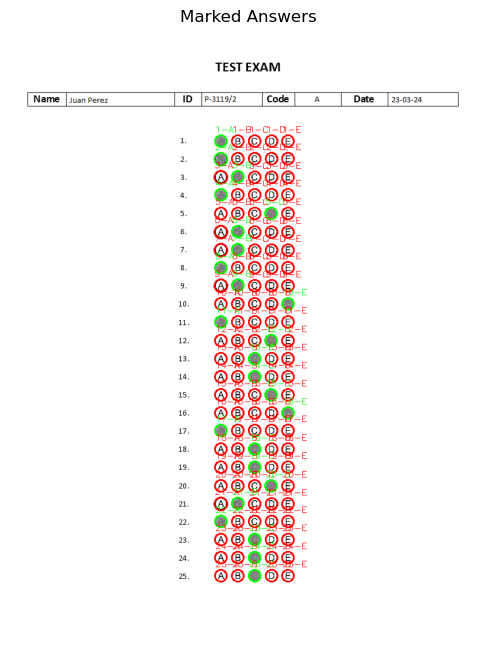

Image processing completed successfully.

Detected answers:
Question 1: A
Question 2: A
Question 3: B
Question 4: A
Question 5: D
Question 6: B
Question 7: B
Question 8: A
Question 9: B
Question 10: E
Question 11: A
Question 12: D
Question 13: C
Question 14: C
Question 15: D
Question 16: E
Question 17: A
Question 18: C
Question 19: C
Question 20: D
Question 21: B
Question 22: A
Question 23: C
Question 24: C
Question 25: C

Evaluation results:
Correct answers: 20
Incorrect answers: 5
Unanswered questions: 0
Score: 75 / 100

Detailed results:
Question 1: Correct=A, Marked=A, Result=Correcta
Question 2: Correct=A, Marked=A, Result=Correcta
Question 3: Correct=B, Marked=B, Result=Correcta
Question 4: Correct=A, Marked=A, Result=Correcta
Question 5: Correct=D, Marked=D, Result=Correcta
Question 6: Correct=B, Marked=B, Result=Correcta
Question 7: Correct=B, Marked=B, Result=Correcta
Question 8: Correct=C, Marked=A, Result=Incorrecta
Question 9: Correct=B, Marked=B, Result=Correcta
Question 1

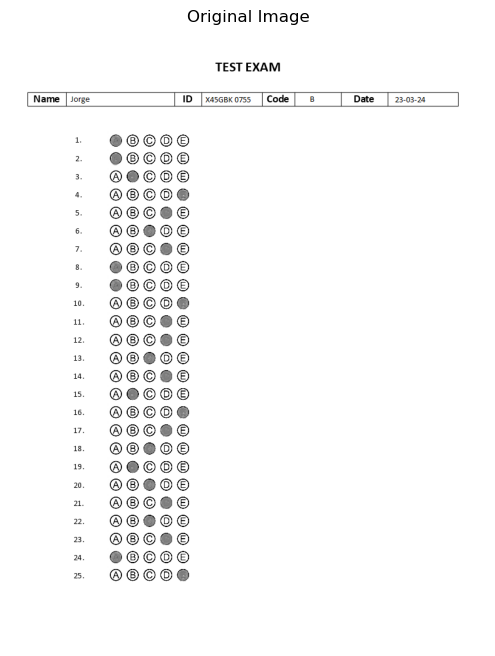

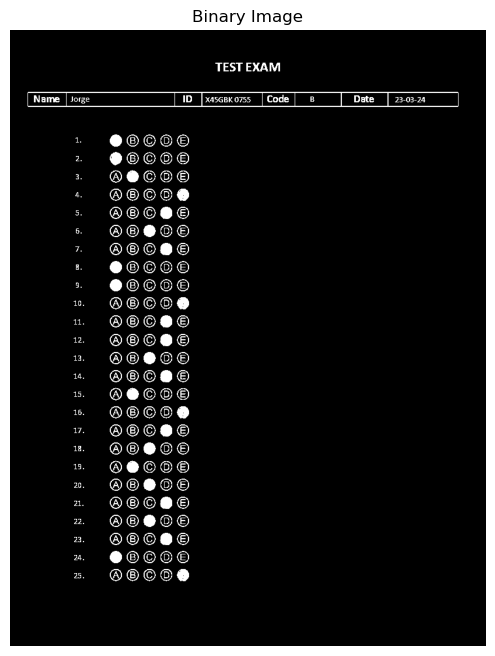

Detected 125 circles
Grouped into 25 questions

Detected answers:
Question 1: A
Question 2: A
Question 3: B
Question 4: E
Question 5: D
Question 6: C
Question 7: D
Question 8: A
Question 9: A
Question 10: E
Question 11: D
Question 12: D
Question 13: C
Question 14: D
Question 15: B
Question 16: E
Question 17: D
Question 18: C
Question 19: B
Question 20: C
Question 21: D
Question 22: C
Question 23: D
Question 24: A
Question 25: E


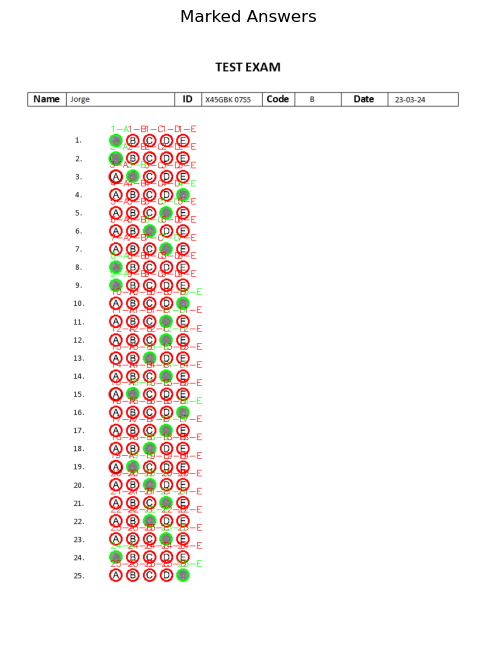

Image processing completed successfully.

Detected answers:
Question 1: A
Question 2: A
Question 3: B
Question 4: E
Question 5: D
Question 6: C
Question 7: D
Question 8: A
Question 9: A
Question 10: E
Question 11: D
Question 12: D
Question 13: C
Question 14: D
Question 15: B
Question 16: E
Question 17: D
Question 18: C
Question 19: B
Question 20: C
Question 21: D
Question 22: C
Question 23: D
Question 24: A
Question 25: E

Evaluation results:
Correct answers: 7
Incorrect answers: 18
Unanswered questions: 0
Score: 10 / 100

Detailed results:
Question 1: Correct=A, Marked=A, Result=Correcta
Question 2: Correct=A, Marked=A, Result=Correcta
Question 3: Correct=B, Marked=B, Result=Correcta
Question 4: Correct=A, Marked=E, Result=Incorrecta
Question 5: Correct=D, Marked=D, Result=Correcta
Question 6: Correct=B, Marked=C, Result=Incorrecta
Question 7: Correct=B, Marked=D, Result=Incorrecta
Question 8: Correct=C, Marked=A, Result=Incorrecta
Question 9: Correct=B, Marked=A, Result=Incorrecta
Qu

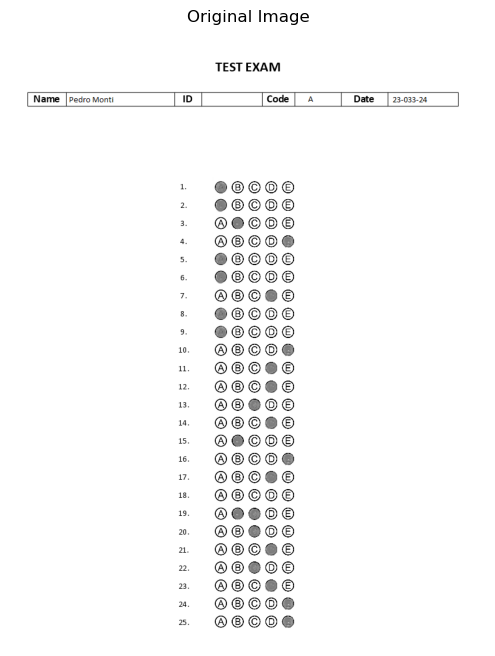

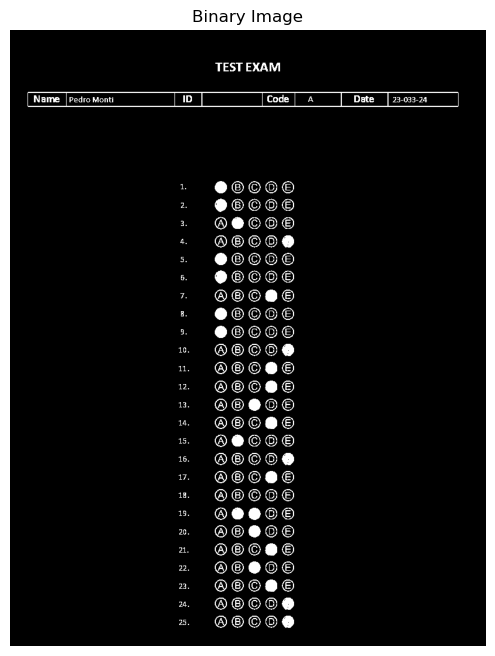

Detected 125 circles
Grouped into 25 questions

Detected answers:
Question 1: A
Question 2: A
Question 3: B
Question 4: E
Question 5: A
Question 6: A
Question 7: D
Question 8: A
Question 9: A
Question 10: E
Question 11: D
Question 12: D
Question 13: C
Question 14: D
Question 15: B
Question 16: E
Question 17: D
Question 18: None marked
Question 19: B, C
Question 20: C
Question 21: D
Question 22: C
Question 23: D
Question 24: E
Question 25: E


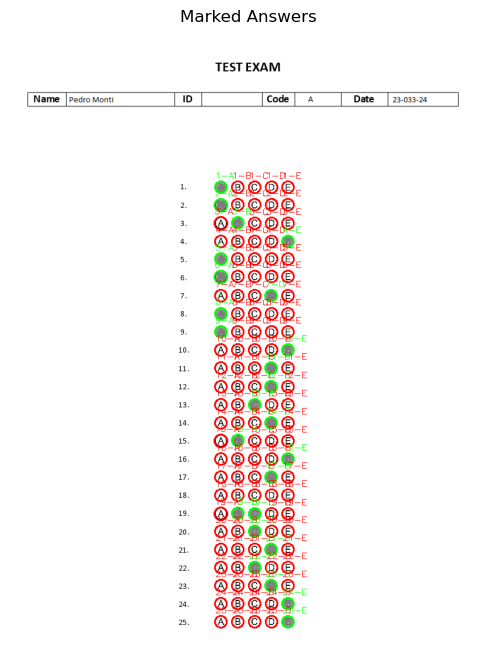

Image processing completed successfully.

Detected answers:
Question 1: A
Question 2: A
Question 3: B
Question 4: E
Question 5: A
Question 6: A
Question 7: D
Question 8: A
Question 9: A
Question 10: E
Question 11: D
Question 12: D
Question 13: C
Question 14: D
Question 15: B
Question 16: E
Question 17: D
Question 18: None marked
Question 19: B, C
Question 20: C
Question 21: D
Question 22: C
Question 23: D
Question 24: E
Question 25: E

Evaluation results:
Correct answers: 5
Incorrect answers: 19
Unanswered questions: 1
Score: 1 / 100

Detailed results:
Question 1: Correct=A, Marked=A, Result=Correcta
Question 2: Correct=A, Marked=A, Result=Correcta
Question 3: Correct=B, Marked=B, Result=Correcta
Question 4: Correct=A, Marked=E, Result=Incorrecta
Question 5: Correct=D, Marked=A, Result=Incorrecta
Question 6: Correct=B, Marked=A, Result=Incorrecta
Question 7: Correct=B, Marked=D, Result=Incorrecta
Question 8: Correct=C, Marked=A, Result=Incorrecta
Question 9: Correct=B, Marked=A, Result

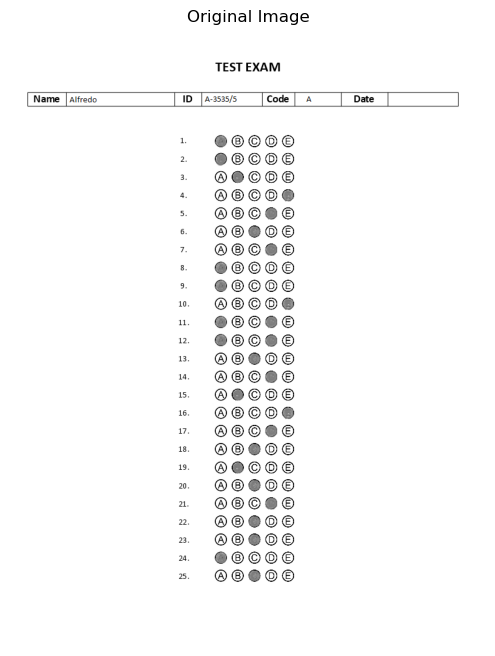

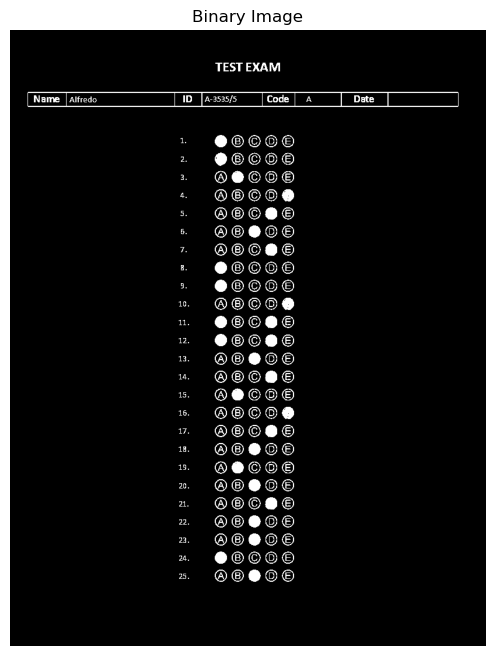

Detected 125 circles
Grouped into 25 questions

Detected answers:
Question 1: A
Question 2: A
Question 3: B
Question 4: E
Question 5: D
Question 6: C
Question 7: D
Question 8: A
Question 9: A
Question 10: E
Question 11: A, D
Question 12: A, D
Question 13: C
Question 14: D
Question 15: B
Question 16: E
Question 17: D
Question 18: C
Question 19: B
Question 20: C
Question 21: D
Question 22: C
Question 23: C
Question 24: A
Question 25: C


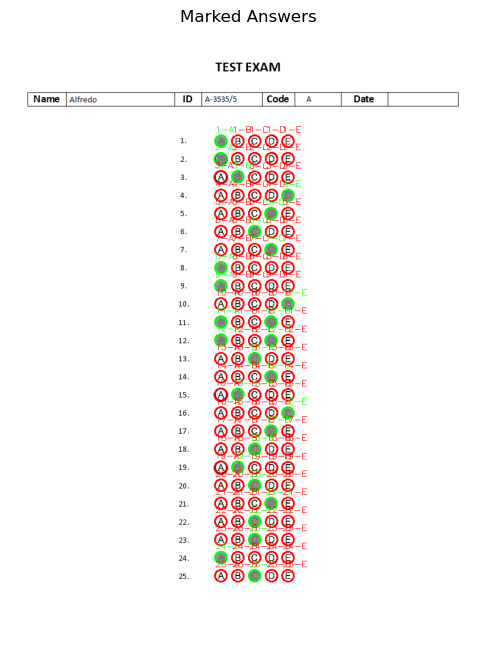

Image processing completed successfully.

Detected answers:
Question 1: A
Question 2: A
Question 3: B
Question 4: E
Question 5: D
Question 6: C
Question 7: D
Question 8: A
Question 9: A
Question 10: E
Question 11: A, D
Question 12: A, D
Question 13: C
Question 14: D
Question 15: B
Question 16: E
Question 17: D
Question 18: C
Question 19: B
Question 20: C
Question 21: D
Question 22: C
Question 23: C
Question 24: A
Question 25: C

Evaluation results:
Correct answers: 8
Incorrect answers: 17
Unanswered questions: 0
Score: 15 / 100

Detailed results:
Question 1: Correct=A, Marked=A, Result=Correcta
Question 2: Correct=A, Marked=A, Result=Correcta
Question 3: Correct=B, Marked=B, Result=Correcta
Question 4: Correct=A, Marked=E, Result=Incorrecta
Question 5: Correct=D, Marked=D, Result=Correcta
Question 6: Correct=B, Marked=C, Result=Incorrecta
Question 7: Correct=B, Marked=D, Result=Incorrecta
Question 8: Correct=C, Marked=A, Result=Incorrecta
Question 9: Correct=B, Marked=A, Result=Incorre

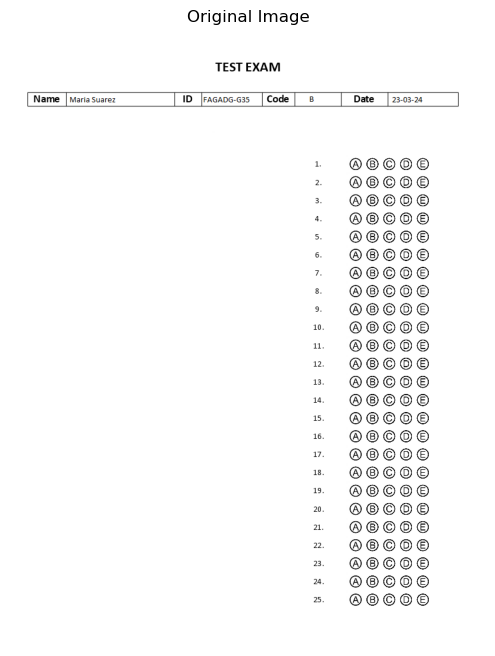

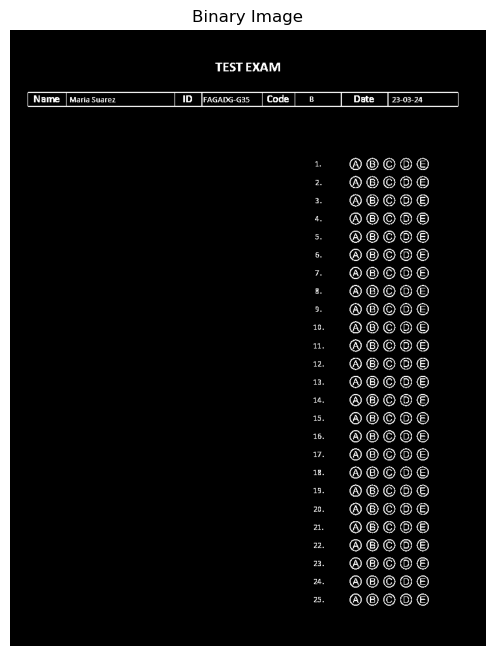

Detected 125 circles
Grouped into 25 questions

Detected answers:
Question 1: None marked
Question 2: None marked
Question 3: None marked
Question 4: None marked
Question 5: None marked
Question 6: None marked
Question 7: None marked
Question 8: None marked
Question 9: None marked
Question 10: None marked
Question 11: None marked
Question 12: None marked
Question 13: None marked
Question 14: None marked
Question 15: None marked
Question 16: None marked
Question 17: None marked
Question 18: None marked
Question 19: None marked
Question 20: None marked
Question 21: None marked
Question 22: None marked
Question 23: None marked
Question 24: None marked
Question 25: None marked


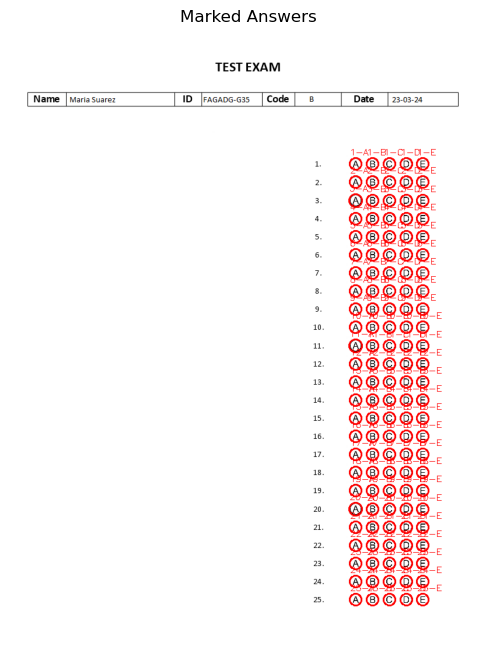

Image processing completed successfully.

Detected answers:
Question 1: None marked
Question 2: None marked
Question 3: None marked
Question 4: None marked
Question 5: None marked
Question 6: None marked
Question 7: None marked
Question 8: None marked
Question 9: None marked
Question 10: None marked
Question 11: None marked
Question 12: None marked
Question 13: None marked
Question 14: None marked
Question 15: None marked
Question 16: None marked
Question 17: None marked
Question 18: None marked
Question 19: None marked
Question 20: None marked
Question 21: None marked
Question 22: None marked
Question 23: None marked
Question 24: None marked
Question 25: None marked

Evaluation results:
Correct answers: 0
Incorrect answers: 0
Unanswered questions: 25
Score: 0 / 100

Detailed results:
Question 1: Correct=A, Marked=None, Result=No contestada
Question 2: Correct=A, Marked=None, Result=No contestada
Question 3: Correct=B, Marked=None, Result=No contestada
Question 4: Correct=A, Marked=Non

In [14]:
for i in range(1,6):
    # Path to the test image
    print(f"EXAMEN N° {i}")
    ruta_imagen = f"./multiple_choice_{i}.png"

    # Check if the image exists
    if not os.path.exists(ruta_imagen):
        print(f"Error: Image not found at {ruta_imagen}")
    else:
        # Read the image
        imagen = cv2.imread(ruta_imagen)
        
        if imagen is None:
            print(f"Error: Could not read the image at {ruta_imagen}")
        else:
            # Display original image
            mostrar_imagen(imagen, "Original Image")
            
            # Get binary image
            binaria = obtener_imagen_binaria(imagen)
            mostrar_imagen(binaria, "Binary Image")
            
            # Detect circles
            circulos_detectados = detectar_circulos(binaria)
            print(f"Detected {len(circulos_detectados)} circles")
            
            # Group circles into questions
            preguntas = agrupar_circulos_en_preguntas(circulos_detectados)
            print(f"Grouped into {len(preguntas)} questions")
            
            # Detect marked circles
            respuestas = detectar_circulos_marcados(imagen, preguntas)
            
            # Print detected answers
            print("\nDetected answers:")
            for num_pregunta, opciones_marcadas in sorted(respuestas.items()):
                print(f"Question {num_pregunta}: {', '.join(opciones_marcadas) if opciones_marcadas else 'None marked'}")
            
            # Visualize answers
            imagen_con_respuestas = visualizar_respuestas(imagen, preguntas, respuestas)
            mostrar_imagen(imagen_con_respuestas, "Marked Answers")
            
            print("Image processing completed successfully.")

                        # Print detected answers
            print("\nDetected answers:")
            for num_pregunta, opciones_marcadas in sorted(respuestas.items()):
                print(f"Question {num_pregunta}: {', '.join(opciones_marcadas) if opciones_marcadas else 'None marked'}")
            
            # Evaluate answers
            resultados = evaluar_respuestas(respuestas, respuestas_correctas)
            
            # Print evaluation results
            print("\nEvaluation results:")
            print(f"Correct answers: {resultados['correctas']}")
            print(f"Incorrect answers: {resultados['incorrectas']}")
            print(f"Unanswered questions: {resultados['no_contestadas']}")
            print(f"Score: {resultados['puntaje']} / {resultados['puntaje_maximo']}")
            
            # Print detailed results if needed
            print("\nDetailed results:")
            for num_pregunta, detalle in sorted(resultados['detalles'].items()):
                marcada = ', '.join(detalle['respuesta_marcada']) if detalle['respuesta_marcada'] else 'None'
                print(f"Question {num_pregunta}: Correct={detalle['respuesta_correcta']}, Marked={marcada}, Result={detalle['resultado']}")
                